<h1><center>Gibbs sampling for the probit model and Complete Separation</center></h1>

Download the German credit dataset available in e.g. the UCI repository:
https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/
german.data-numeric
We would like to classify the last column (good vs bad credit) based on the
previous columns (see the UCI repository for more information on each variable).
To do so, we consider the probit model, where $y_i = sgn(\beta^Tx_i+\epsilon_i)$, and $\epsilon_i \sim \mathcal{N}(0, 1)$
and a Gaussian prior $\beta \sim \mathcal{N}(0, \tau I_p)$ with p = dim $\beta$, and $\tau = 10^2$.


In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import truncnorm,mode
import time

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric

--2020-01-12 19:18:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102000 (100K) [application/x-httpd-php]
Saving to: ‘german.data-numeric’

german.data-numeric 100%[===================>]  99.61K   518KB/s    in 0.2s    

2020-01-12 19:18:09 (518 KB/s) - ‘german.data-numeric’ saved [102000/102000]



In [0]:
data = pd.read_csv('/content/german.data-numeric', header= None, delimiter= '\s+', index_col=False)
X=data.iloc[:,:-1]
cols = ["x"+str(i) for i in X.columns]
X.columns = cols
y=data.iloc[:,-1]
#Normalisation
X=(X-X.mean())/X.std()
#adding a constant column 
X.insert(0,'cte', 1)
#casting y values to +1 / -1 
y=y*2-3

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=.2)

#Gibbs Sampling


The theory Behind Gibbs Sampling Is available on The Report.pdf

we need to sequentially sample the following ( we start off with a burn in period) :(check report for more details ) 
*  $\beta^{t+1} \sim p(\beta|z^t) = \mathcal N(\mu_p^t, \Sigma_p) ,\quad
    \Sigma_p = (\frac1\tau I_p + X^TX)^{-1},
    \quad
    \mu^t = \Sigma_p X^Tz 
$

*  $z^{t+1} \sim \mathcal{N} (x_i^T\beta, 1; y_i)[z_i y_i>0] \quad \text{such that }p(z|\beta^{t+1},y^t) = \exp(-\frac12\|z-X\beta\|^2) \prod_i \mathbf{1}_{\{y_iz_i > 0\}}$






In [0]:
class GibbsSampler:
    """Gibbs sampler for the graphical model."""
    def __init__(self,tau=10**2, burn_in=1000):
        self.burn_in = burn_in
        self.tau = tau

    def sample(self,X,y, n_iter):
        """Sampling from the posterior distribution.
        -----------------------------------------------------------------
        Input:
            n_iter : number of iterations 
        ------------------------------------------------------------------            
        Output:
            beta_samples, z_samples : samples from the posterior 
        """
        n,p = X.shape
        # posterior dist init 
        # covariance matrix
        cov_ = np.linalg.inv(np.eye(p)/ self.tau + X.T @ X) 
        #z randomly initialized : 
        z = np.random.randn(n)
        # mean
        mu = cov_@X.T@z
        temp = cov_ @ X.T #we don't need to calculate this every time
        beta_samples= []
        z_samples=[]
        for t in range(self.burn_in+n_iter):
            ## Sample beta
            beta = np.random.multivariate_normal(mu, cov=cov_)
            ## Sample z
            mean = X@beta
            a=np.where(y<0,-np.inf,-mean)
            b=np.where(y>0,np.inf,-mean)
            z= truncnorm.rvs(a, b, loc=mean)
            mu = temp @ z  # shape (d,)
            if t >= self.burn_in:
                beta_samples+=[beta]
                z_samples+=[z]
        return np.array(beta_samples), np.array(z_samples)

In [0]:
gi_sampler = GibbsSampler(burn_in=1000)

In [7]:
start_time = time.time()
betas, zs = gi_sampler.sample(X_train,y_train,5000)
print("Sampling Time: %.3f" % (time.time()-start_time))

Sampling Time: 82.225


<Figure size 792x432 with 0 Axes>

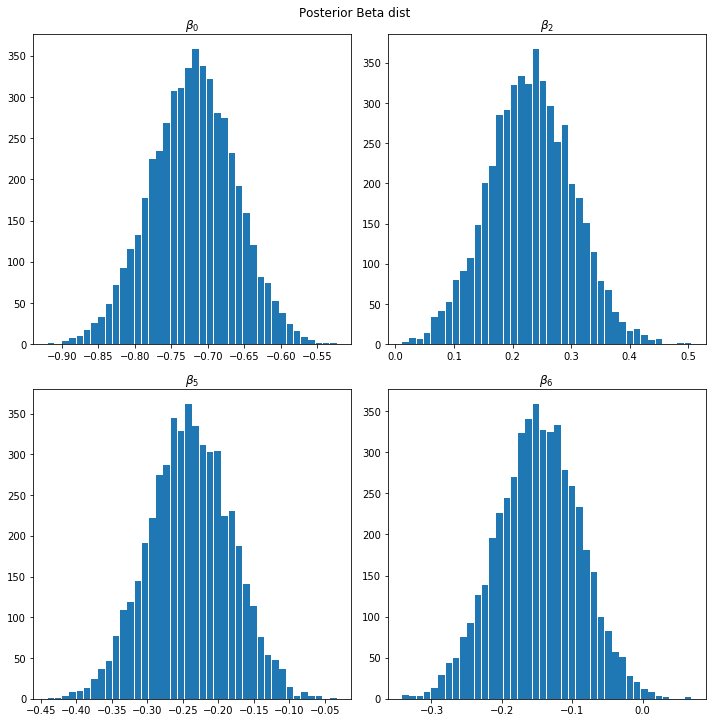

In [8]:
fig = plt.figure(figsize=(11, 6))
nrows = 2
ncols = 2
n_bins = 40
fig,axes=plt.subplots(nrows,ncols,figsize=(10,10))
axes=axes.ravel()
indices=[0,2,5,6]
for i,idx in enumerate(indices):
  axes[i].hist(betas[:, idx], bins=n_bins,rwidth=.9 )
  axes[i].set_title('$\\beta_{%d}$' % idx)
fig.tight_layout()
fig.suptitle("Posterior Beta dist ", y=1.);

<Figure size 792x432 with 0 Axes>

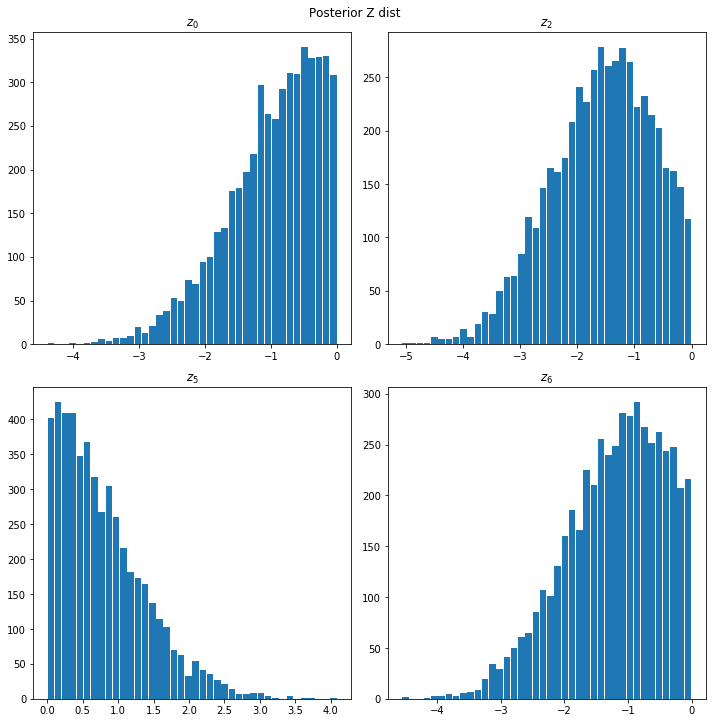

In [9]:
fig = plt.figure(figsize=(11, 6))
nrows = 2
ncols = 2
n_bins = 40
fig,axes=plt.subplots(nrows,ncols,figsize=(10,10))
axes=axes.ravel()
indices=[0,2,5,6]
for i,idx in enumerate(indices):
  axes[i].hist(zs[:, idx], bins=n_bins,rwidth=.9 )
  axes[i].set_title('$z_{%d}$' % idx)
fig.tight_layout()
fig.suptitle("Posterior Z dist ", y=1.);

In [0]:
def predict(X,betas):
        n= X.shape[0]
        n_samples=betas.shape[0]
        Z = X @betas.T + np.random.randn(n,n_samples )
        Y=np.sign(np.sum(np.sign(Z),axis=1))
        return Y #return most probable output 

In [0]:
y_pred=predict(X_test,betas)

we get an accuracy of around 80%



In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.81      0.95      0.87       139
           1       0.81      0.49      0.61        61

    accuracy                           0.81       200
   macro avg       0.81      0.72      0.74       200
weighted avg       0.81      0.81      0.79       200



# Complete Separation 

Complete separation occurs in a dataset if there exists β such that
$y_iβ\beta^Tx_i > 0 $ for all the datapoints.  maximum likelihood estimation is not  possible in this  case but we'll see that Gibbs sampling performs very well. 

## Creating synthetic Completely seperable dataset 

In [0]:
x = np.random.randn(500, 2)
beta = np.array([1.5, 1.5])
sep = x @ beta + 2 > 0.
x1 = x[sep]+[0.5,0.5]
x2 = x[~sep]-[0.5,.5]#we add more seperation like this 

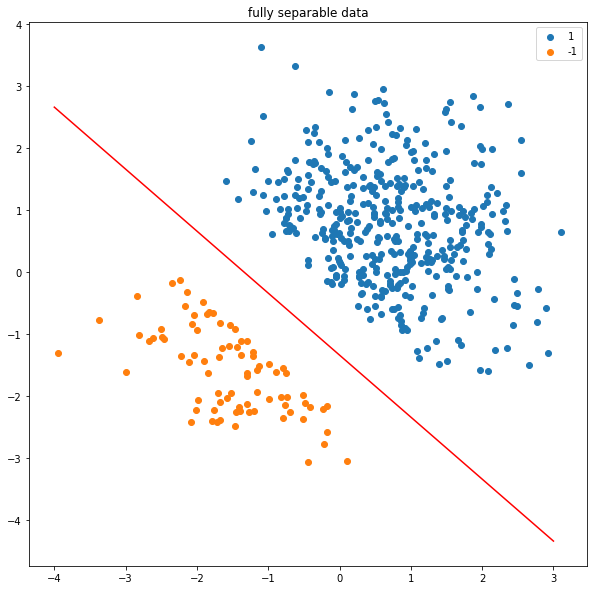

In [14]:
fig = plt.figure(figsize=(10,10))
plt.scatter(*x1.T,label="1")
plt.scatter(*x2.T,  label="-1")
t=np.linspace(-4,3,10)
line=(beta[0]*t+2)/(-beta[1])
plt.plot(t,line,color='r')
plt.title("fully separable data")
plt.legend()

## Testing Our Gibbs Sampler on the separable Dataset 

In [0]:
X=np.vstack((x1,x2))
y = np.ones((x.shape[0],))
y1 = y[sep]
y2 = -y[~sep]
Y=np.append(y1,y2)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

In [0]:
gi_sampler = GibbsSampler(burn_in=1000)
start_time = time.time()
betas, zs = gi_sampler.sample(X_train,y_train,5000)
print("Sampling time: %.3f" % (time.time()-start_time))

Sampling time: 24.706


In [0]:
y_pred=predict(X_test,betas)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        -1.0       0.88      1.00      0.94        15
         1.0       1.00      0.98      0.99        85

    accuracy                           0.98       100
   macro avg       0.94      0.99      0.96       100
weighted avg       0.98      0.98      0.98       100

